## MVO Notebook with L/S Ideas
* FF factors
* 5 L/S ideas
* yfinance and realistic data download

mean variance optimization for long-short portfolios, constraints is that sum of weights is zero, each weight is positive. -->

In [1]:
# Backtest-ready Market-Neutral Idea Portfolio (Rolling Optimization)
# - base_alpha (factor-residual)
# - conviction overlay optional
# - Barra-style synthetic factor covariance OR Ledoit-Wolf sample cov
# - rolling rebalancing, turnover penalty, transaction costs
# - performance, turnover, and weight plots
#
# Requirements:
#   numpy, pandas, matplotlib, statsmodels, scikit-learn, cvxpy, osqp
#
# Notes:
#  - This notebook uses simulated returns without external data.


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.covariance import LedoitWolf
import cvxpy as cp
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
np.random.seed(123)
import yfinance as yf


In [3]:
# =====================================================
# 2. Parameters
# =====================================================
tickers = ["T", "NVDA", "MSFT", "AAPL", "META", "INTC", "AMZN", "AVGO", "GOOG", "AMD"]
start, end = "2024-01-01", "2024-10-31"

# =====================================================
# 3. Download daily prices and compute returns
# =====================================================
# yf.pdr_override()
prices = yf.download(tickers, start=start, end=end)["Close"]
R_assets = prices.pct_change().dropna()
R_assets

/var/folders/0x/cpw5m7p54c7bkvtwg77cln500000gn/T/ipykernel_4241/830022432.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end)["Close"]
[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMD,AMZN,AVGO,GOOG,INTC,META,MSFT,NVDA,T
Date,,,,,,,,,,
2024-01-03,-0.007488,-0.023524,-0.009738,-0.024692,0.005732,-0.015690,-0.005256,-0.000728,-0.012436,-0.001159
2024-01-04,-0.012700,0.005099,-0.026268,-0.009040,-0.016529,-0.003826,0.007693,-0.007177,0.009019,-0.004643
2024-01-05,-0.004013,0.018896,0.004634,0.000257,-0.004709,0.000427,0.013915,-0.000516,0.022897,0.018659
2024-01-08,0.024175,0.054842,0.026577,0.024369,0.022855,0.033270,0.019065,0.018871,0.064281,-0.008586
2024-01-09,-0.002263,0.021070,0.015225,0.007108,0.014445,-0.008256,-0.003429,0.002936,0.016975,-0.005398
...,...,...,...,...,...,...,...,...,...,...
2024-10-24,-0.000823,0.003466,0.009041,-0.012449,0.000304,0.016379,0.007256,0.000306,0.006091,-0.012894
2024-10-25,0.003643,0.018183,0.007780,0.009629,0.014952,0.015219,0.009634,0.008052,0.008048,-0.016667
2024-10-28,0.008599,0.023619,0.002981,-0.005665,0.008084,0.010582,0.008565,-0.003644,-0.007206,0.012826


In [4]:
# =====================================================
# 4. Download Fama-French 5 factors (daily)
# =====================================================

ff = pdr.DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench", start=start, end=end)[0]
ff = ff / 100  # convert % to decimals
ff = ff.loc[R_assets.index]  # align dates
factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]
Rf = ff["RF"]
factors = ff[factor_cols]
factors

/var/folders/0x/cpw5m7p54c7bkvtwg77cln500000gn/T/ipykernel_4241/1174600903.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench", start=start, end=end)[0]


,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2024-01-03,-0.0101,-0.0193,-0.0011,0.0036,-0.0019
2024-01-04,-0.0033,0.0024,0.0009,-0.0043,0.0024
2024-01-05,0.0015,-0.0059,0.0063,0.0010,-0.0017
2024-01-08,0.0149,0.0054,-0.0127,-0.0097,-0.0044
2024-01-09,-0.0021,-0.0075,-0.0089,-0.0029,-0.0017
...,...,...,...,...,...
2024-10-24,0.0029,0.0008,-0.0029,-0.0002,-0.0034
2024-10-25,-0.0008,-0.0027,-0.0082,0.0007,-0.0032
2024-10-28,0.0038,0.0134,0.0063,-0.0060,-0.0009


In [5]:
# =====================================================
# 5. Estimate factor betas (B_assets)
# =====================================================
B_assets = pd.DataFrame(index=tickers, columns=factor_cols)

for t in tickers:
    y = R_assets[t] - Rf
    X = sm.add_constant(factors)
    model = sm.OLS(y, X, missing='drop').fit()
    B_assets.loc[t] = model.params[factor_cols]

B_assets = B_assets.astype(float)
print("Estimated factor betas:")
display(B_assets)

Estimated factor betas:


,Mkt-RF,SMB,HML,RMW,CMA
T,0.028837,-0.136597,0.702351,-0.157092,0.431740
NVDA,2.656044,-0.792219,-1.526017,0.540841,0.580659
MSFT,1.051186,-0.236354,-0.234339,-0.002653,-0.645965
AAPL,0.922110,0.344747,-0.602837,0.796751,0.049918
META,1.465511,-0.786867,-0.067055,-0.695096,-1.523048
INTC,2.191333,-0.812492,0.824878,-1.487918,0.401216
AMZN,1.308584,-0.296342,-0.174855,-0.597568,-1.124736
AVGO,2.523802,-0.299860,-1.116547,1.055226,0.837486
GOOG,1.097604,-0.027445,-0.350695,0.244942,-0.456039
AMD,2.082186,-0.802375,-0.323370,-1.265228,-0.272115


In [6]:
# =====================================================
# 6. Define long-short ideas (market-neutral pairs)
# =====================================================
ideas = {
    "Idea1_NVDA_long_INTC_short": ("NVDA", "INTC"),
    "Idea2_META_long_GOOG_short": ("META", "GOOG"),
    "Idea3_AMZN_long_AVGO_short": ("AMZN", "AVGO"),
    "Idea4_MSFT_long_T_short": ("MSFT", "T"),
    "Idea5_AAPL_long_AMD_short": ("AAPL", "AMD"),
}

# =====================================================
# 7. Compute daily returns of each idea
# =====================================================
idea_returns = pd.DataFrame(index=R_assets.index)
for name, (long_t, short_t) in ideas.items():
    idea_returns[name] = R_assets[long_t] - R_assets[short_t]
idea_returns

,Idea1_NVDA_long_INTC_short,Idea2_META_long_GOOG_short,Idea3_AMZN_long_AVGO_short,Idea4_MSFT_long_T_short,Idea5_AAPL_long_AMD_short
Date,,,,,
2024-01-03,0.003255,-0.010988,0.014954,0.000432,0.016037
2024-01-04,0.012844,0.024222,-0.017228,-0.002535,-0.017799
2024-01-05,0.022470,0.018623,0.004377,-0.019175,-0.022909
2024-01-08,0.031011,-0.003789,0.002208,0.027457,-0.030667
2024-01-09,0.025231,-0.017875,0.008117,0.008334,-0.023333
...,...,...,...,...,...
2024-10-24,-0.010288,0.006952,0.021490,0.013201,-0.004289
2024-10-25,-0.007172,-0.005318,-0.001850,0.024719,-0.014540
2024-10-28,-0.017788,0.000481,0.008646,-0.016470,-0.015020


In [10]:
# =====================================================
# 8. Estimate expected returns (alphas) for each idea
# =====================================================
expected_alpha = idea_returns.mean() * 252  # annualized mean daily return
cov_matrix = idea_returns.cov() * 252       # annualized covariance

print("Expected alpha (annualized):")
display(expected_alpha)

Expected alpha (annualized):


Idea1_NVDA_long_INTC_short    2.194243
Idea2_META_long_GOOG_short    0.400722
Idea3_AMZN_long_AVGO_short   -0.373721
Idea4_MSFT_long_T_short      -0.176608
Idea5_AAPL_long_AMD_short     0.082095
dtype: float64

In [11]:
print("\nCovariance matrix (annualized):")
cov_matrix


Covariance matrix (annualized):


,Idea1_NVDA_long_INTC_short,Idea2_META_long_GOOG_short,Idea3_AMZN_long_AVGO_short,Idea4_MSFT_long_T_short,Idea5_AAPL_long_AMD_short
Idea1_NVDA_long_INTC_short,0.386913,0.026717,-0.085499,0.043518,-0.059390
Idea2_META_long_GOOG_short,0.026717,0.141604,-0.002246,0.015368,-0.033850
Idea3_AMZN_long_AVGO_short,-0.085499,-0.002246,0.183209,-0.029100,0.069238
Idea4_MSFT_long_T_short,0.043518,0.015368,-0.029100,0.095325,-0.026318
Idea5_AAPL_long_AMD_short,-0.059390,-0.033850,0.069238,-0.026318,0.242133



Optimized Idea Weights:


Idea1_NVDA_long_INTC_short    0.378685
Idea2_META_long_GOOG_short    0.275480
Idea3_AMZN_long_AVGO_short    0.123400
Idea4_MSFT_long_T_short       0.016366
Idea5_AAPL_long_AMD_short     0.206068
dtype: float64

Annualized Return: 90.92%
Annualized Volatility: 25.99%
Sharpe Ratio: 3.50


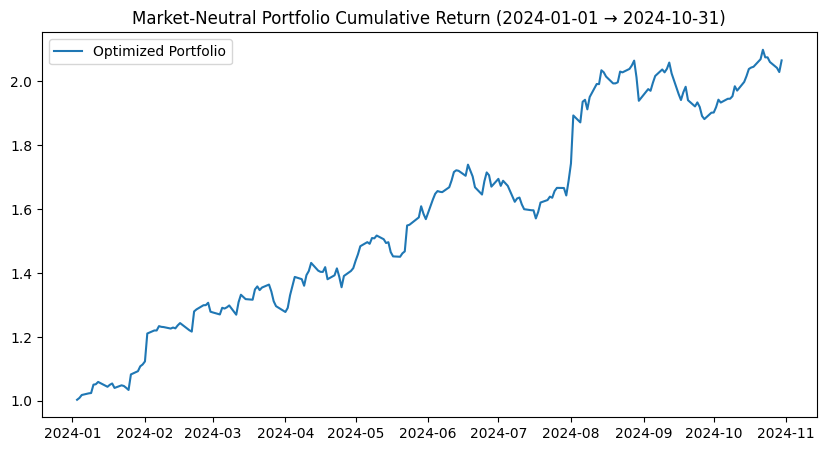

In [8]:
# =====================================================
# 9. Mean–variance optimization 
# =====================================================
n_ideas = len(ideas)
w = cp.Variable(n_ideas)

mu = expected_alpha.values
Sigma = cov_matrix.values

# Objective: maximize Sharpe ratio = mu' w / sqrt(w' Σ w)
# Equivalent to maximize mu' w - λ * w' Σ w
risk_aversion = 10.0
objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, Sigma))

# Constraints
constraints = [
    w >= 0,          # only positive weights (conviction or capital allocation)
    cp.sum(w) == 1,  # fully allocated
]

prob = cp.Problem(objective, constraints)
prob.solve()

weights = pd.Series(w.value, index=idea_returns.columns)
print("\nOptimized Idea Weights:")
display(weights)

# =====================================================
# 10. Portfolio performance
# =====================================================
portfolio_daily = idea_returns @ weights
portfolio_cum = (1 + portfolio_daily).cumprod()

print(f"Annualized Return: {portfolio_daily.mean() * 252:.2%}")
print(f"Annualized Volatility: {portfolio_daily.std() * np.sqrt(252):.2%}")
print(f"Sharpe Ratio: {(portfolio_daily.mean() / portfolio_daily.std()) * np.sqrt(252):.2f}")

# =====================================================
# 11. Plot performance
# =====================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(portfolio_cum, label="Optimized Portfolio")
plt.title("Market‐Neutral Portfolio Cumulative Return (2024-01-01 → 2024-10-31)")
plt.legend()
plt.show()